# Machine Learning Project 

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import PIL
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm
from PIL import Image
from helper_func import load_image, PIL_resize
from matplotlib.pyplot import imshow


## Preprocess Image
Load the data from the dataset folder and resize the picture.


In [2]:
train = pd.read_csv('garbage-classification/zero-indexed-files.csv')
data = []
labels = train['Label'].values
for i in tqdm(range(train.shape[0])):
    img = load_image('garbage-classification/data/'+train['Name'][i]+'.jpg')
    img = PIL_resize(img, (0.1,0.1))
    data.append(img)
data = np.asarray(data)
print("Training data size: ", data.shape)
print("Training label size: ", labels.shape)

100%|██████████| 2527/2527 [00:22<00:00, 114.33it/s]

Training data size:  (2527, 38, 51, 3)
Training label size:  (2527,)


## Training Data and Testing Data
We will randomly select a portion of data for training and using the rest of them for testing. We can change the ratio of $\frac{\text{training data}}{\text{testing data}}$ to improve the performance of our network.

In [3]:
num_classified = 6
classified_name = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]

classified_start_idx = np.zeros(num_classified, dtype=int)
classified_size = np.zeros(num_classified, dtype=int)
temp_count = 0
for i in range(num_classified):
    classified_start_idx[i] = temp_count
    size = np.count_nonzero(labels == i)
    classified_size[i] = size
    temp_count += size
    
print("Class name: ", classified_name)
print("Class start index:", classified_start_idx)

Class name:  ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
Class start index: [   0  501 1095 1498 1980 2390]


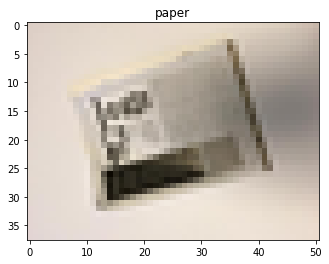

In [4]:
plt.figure()
display_idx = 1
plt.title(classified_name[display_idx])
imshow(data[classified_start_idx[display_idx]])

In [5]:
training_ratio = 0.9

training_data_size = np.array(training_ratio*classified_size, dtype=int)
testing_data_size = classified_size - training_data_size
print(classified_size)
print(training_data_size)
print(testing_data_size)

[501 594 403 482 410 137]
[450 534 362 433 369 123]
[51 60 41 49 41 14]


In [6]:
training_idx = np.array([], dtype=int)
testing_idx = np.array([], dtype=int)
for i in range(num_classified):
    selected = np.random.choice(classified_size[i],size=training_data_size[i],  replace=False)
    each = np.arange(classified_size[i])
    training_idx = np.concatenate((training_idx, selected+classified_start_idx[i]), axis=0)
    testing_idx = np.concatenate((testing_idx, np.setdiff1d(each, selected)+classified_start_idx[i]), axis=0)
training_idx = np.random.permutation(training_idx)
testing_idx = np.random.permutation(testing_idx)
print(training_idx)

[ 578  274  506 ... 1306 1155  818]


In [7]:
def convert_to_one_hot(x, classes):
    one_hot = np.zeros((x.shape[0], classes), dtype=int)
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

In [8]:
labels = train['Label'].values
training_data = data[training_idx]
training_labels = labels[training_idx]
testing_data = data[testing_idx]
testing_labels = labels[testing_idx]
training_data = np.swapaxes(training_data, 1,3)
training_data = np.swapaxes(training_data, 2,3)
testing_data = np.swapaxes(testing_data, 1,3)
testing_data = np.swapaxes(testing_data, 2,3)

training_data = torch.from_numpy(training_data)
training_labels = torch.from_numpy(training_labels)
testing_data = torch.from_numpy(testing_data)
testing_labels = torch.from_numpy(testing_labels)
print("Training data shape: ", training_data.shape)
print("Training labels shape: ", training_labels.shape)
print("Testing data shape: ", testing_data.shape)
print("Testing labels shape: ", testing_labels.shape)

Training data shape:  torch.Size([2271, 3, 38, 51])
Training labels shape:  torch.Size([2271])
Testing data shape:  torch.Size([256, 3, 38, 51])
Testing labels shape:  torch.Size([256])


In [9]:
def create_batches(data, labels, batch_size=4):
    mini_batch_data = torch.split(data, batch_size, dim=0)[:-1]
    mini_batch_labels = torch.split(labels, batch_size, dim=0)[:-1]
    batches = []
    for i in range(len(mini_batch_data)):
        batches.append((mini_batch_data[i], mini_batch_labels[i]))    
    return batches

batch_size = 4
training_batches = create_batches(training_data, training_labels, batch_size)
testing_batches = create_batches(testing_data, testing_labels, batch_size)

## Neural Network Architecture

In [50]:
class Net(nn.Module):
    def __init__(self, batch_size=4, height=192, width=256):
        super(Net, self).__init__()
        kernel_size = 3
        self.num_feature_map = 64
        self.num_hidden_unit = 120
        self.width = width
        self.height = height
        self.batch_size = batch_size
        
        self.conv1 = nn.Conv2d(3, self.num_feature_map, kernel_size=kernel_size, padding=(kernel_size//2), bias=False)
#         self.conv2 = nn.Conv2d(32, self.num_feature_map, kernel_size=kernel_size, padding=(kernel_size//2))
        self.fc1 = nn.Linear(self.num_feature_map * width * height, self.num_hidden_unit)
        self.fc2 = nn.Linear(self.num_hidden_unit, 64)
        self.fc3 = nn.Linear(64, num_classified)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_feature_map * self.width * self.height)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
#         x = self.fc3(x)
        return x
    
net = Net(batch_size=batch_size, height=training_data.shape[2], width=training_data.shape[3])

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

In [55]:
running_loss = 0.0
epoch = 0
for i in tqdm(range(len(training_batches))):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = training_batches[i]
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()
    
    print_batches = 50
    if i % print_batches == (print_batches-1):    # print every 50 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / print_batches))
        running_loss = 0.0
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

  9%|▉         | 51/567 [00:04<00:44, 11.66it/s]

[1,    50] loss: 1.763


 18%|█▊        | 101/567 [00:08<00:38, 11.96it/s]

[1,   100] loss: 1.759


 27%|██▋       | 151/567 [00:13<00:35, 11.77it/s]

[1,   150] loss: 1.760


 35%|███▌      | 201/567 [00:17<00:31, 11.79it/s]

[1,   200] loss: 1.774


 44%|████▍     | 251/567 [00:21<00:26, 11.87it/s]

[1,   250] loss: 1.740


 53%|█████▎    | 301/567 [00:25<00:22, 11.83it/s]

[1,   300] loss: 1.771


 62%|██████▏   | 351/567 [00:30<00:18, 11.83it/s]

[1,   350] loss: 1.764


 71%|███████   | 402/567 [00:34<00:15, 10.97it/s]

[1,   400] loss: 1.752


 80%|███████▉  | 452/567 [00:39<00:09, 11.93it/s]

[1,   450] loss: 1.774


 89%|████████▊ | 502/567 [00:43<00:05, 11.72it/s]

[1,   500] loss: 1.766


 97%|█████████▋| 552/567 [00:47<00:01, 11.56it/s]

[1,   550] loss: 1.752


100%|██████████| 567/567 [00:49<00:00, 11.56it/s]


tensor([[0.2292, 0.4580, 0.0264, 0.2495, 0.0336, 0.0034],
        [0.2343, 0.3843, 0.0510, 0.2586, 0.0605, 0.0112],
        [0.2338, 0.4220, 0.0372, 0.2536, 0.0469, 0.0064],
        [0.2364, 0.4166, 0.0403, 0.2470, 0.0523, 0.0075]],
       grad_fn=<SoftmaxBackward>)
GroundTruth:  metal plastic metal glass
Predicted:  paper paper paper paper


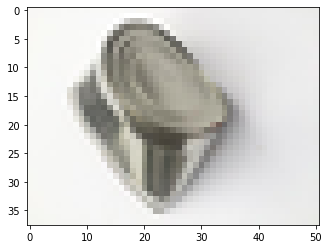

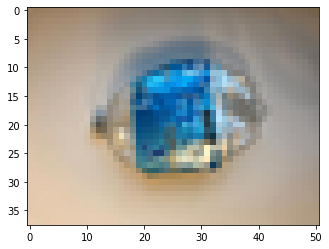

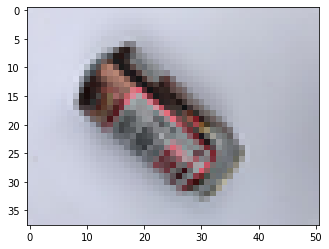

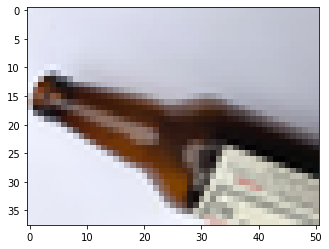

In [56]:

net.load_state_dict(torch.load(PATH))
t1, t2 = testing_batches[0]
for i in range(t1.shape[0]):
    plt.figure()
    temp = np.swapaxes(t1[i], 0,2)
    temp = np.swapaxes(temp, 0,1)
    imshow(temp)
    
outputs = net(t1)
print(outputs)
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % classified_name[t2[j]]
                              for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classified_name[predicted[j]]
                              for j in range(4)))


## Testing the accuracy

In [40]:
correct_match = 0
test_size = len(testing_batches) * batch_size

for i in range(len(testing_batches)):
    data, labels = testing_batches[i]
    outputs = net(data)
    _, predicted = torch.max(outputs, 1)
    matches = np.intersect1d(predicted, labels)
    correct_match += len(matches)
accuracy = correct_match/test_size
print(accuracy)

0.14682539682539683
